# TP3 - quasi-Newton et gradient stochastique

In [1]:
import random

In [2]:
%pylab inline

def RLW(xk,dk,f,df):
    # xk et dk sont consideres comme etant des tableaux (array) 1D
    # De meme, df doit retourner un array 1D
    c1 = 0.1
    c2 = 0.9
    tg = 0.0
    alpha = 1.0
    td = 2.0
    
    fx = f(xk)
    gx = df(xk)
    ps = dot(gx,dk)
    xnew = xk+alpha*dk
    while (f(xnew) > fx+c1*alpha*ps) or (dot(df(xnew),dk) < c2*ps):
        if f(xnew) > fx+c1*alpha*ps:
            td = alpha
        else:
            tg = alpha
        alpha = (tg+td)/2
        xnew = xk+alpha*dk
    return alpha

def RLWp(xk,dk,f,df,param):
    # xk et dk sont consideres comme etant des tableaux (array) 1D
    # De meme, df doit retourner un array 1D
    c1 = 0.1
    c2 = 0.9
    tg = 0.0
    alpha = 1.0
    td = 2.0
    
    fx = f(xk,param)
    gx = df(xk,param)
    ps = dot(gx,dk)
    xnew = xk+alpha*dk
    while (f(xnew,param) > fx+c1*alpha*ps) or (dot(df(xnew,param),dk) < c2*ps):
        if f(xnew,param) > fx+c1*alpha*ps:
            td = alpha
        else:
            tg = alpha
        alpha = (tg+td)/2
        xnew = xk+alpha*dk
    return alpha

Populating the interactive namespace from numpy and matplotlib


C:\Users\Romain\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Exercice 1 - une méthode de quasi-Newton : BFGS

On se donne $f : \mathbb{R}^n \to \mathbb{R}$ deux fois différentiable.

On rappelle qu'une méthode de quasi-Newton pour minimiser $f$ est 
de se donner un point de départ $x_0 \in \mathbb{R}^n$
et de construire la suite suivante : 
$$
x_{k+1} = x_k+\alpha_k d_k,
$$
où 
+ $\alpha_k$ est le résultat d'une recherche linéaire dite de Wolfe (l'une des fonctions RLW, RLWp fournies ci-dessus) ; 
+ $d_k$ est solution de $B_k d_k = -\nabla f(x_k)$ ; 
+ et $B_k$ est une matrice qui "approche" la matrice hessienne de $f$ au point $x_k$.

L'une des méthodes de quasi-Newton les plus utilisées est celle de BFGS (initiales des auteurs Broyden, Fletcher, Goldfarb et Shanno). Elle consiste à construire la matrice $B_k$ itérativement en partant de $B_0 = I_n$ et en effectuant la mise à jour suivante : 
$$
B_{k+1} = B_k
+\dfrac{y_k y_k^\top}{y_k^\top s_k}
-\dfrac{B_ks_ks_k^\top B_k}{s_k^\top B_k s_k},
$$
avec $s_k = x_{k+1}-x_k$ et 
$y_k = \nabla f(x_{k+1})-\nabla f(x_k)$.

## 1) Mise en oeuvre de la méthode de BFGS

Ecrire une fonction **BFGS(f,df,x0,tolg,itmax)** qui construit la suite décrite ci-dessus pour la fonction nommée **f**, dont le gradient est calculé en appelant **df**. On partira du point de départ **x0** et on arrêtera la construction de la suite si on atteint le nombre maximum d'itérations **itmax** ou bien si la norme du gradient de la fonction minimisée est en-dessous de **tolg**.

On utilisera la fonction RLW définie ci-dessus pour réaliser la recherche linéaire de Wolfe.

Cette fonction devra retourner la liste de tous les itérés calculés.

Indication : on pourra utiliser **linalg.solve** pour résoudre un système linéaire.

In [2]:
def BFGS(f,df,x0,tolg,itmax) :
    Beta_k = eye(size(x0))
    xk = [x0]
    norme_gradient = tolg
    i=0
    while (norme_gradient >= tolg and i<itmax):
        gradient = np.array(df(xk[i]))
        norme_gradient = np.linalg.norm(gradient)
        dk = linalg.solve(Beta_k,-1*gradient)
        alpha_k = RLW(xk[i],dk,f,df)
        xk.append(list(xk[i]+alpha_k*dk))
        sk = np.array(xk[i+1])-np.array(xk[i])
        yk = np.array(df(xk[i+1])) - np.array(df(xk[i]))
        #a = matmul(yk.reshape(len(x0),1),yk.reshape(1,len(x0)))
        #b = matmul(yk.reshape(1,len(x0)),sk.reshape(len(x0),1))
        #c = matmul(Beta_k.reshape(len(x0),len(x0)),sk.reshape(len(x0),1),sk.reshape(len(x0),1))
        a = np.matrix(yk).transpose()*np.matrix(yk)
        b = np.matrix(yk).transpose()*np.matrix(sk)
        c = np.matrix(Beta_k)*np.matrix(sk).transpose()*np.matrix(sk)*np.matrix(Beta_k)
        d = np.matrix(sk)*np.matrix(Beta_k)*np.matrix(sk).transpose()
        Beta_k = Beta_k + a/b - c
        i=i+1
    return(xk)

## 2) Test de la méthode de BFGS

### a) Appel de BFGS

Appeler la fonction **BFGS** écrite à la question 1 pour minimiser la fonction de Rosenbrock déjà utilisée au TP2, en partant de $x_0 = (-1.2,1)$ avec **itmax = 100** et **tolg** $=10^{-10}$.

In [30]:
def df(x):
    p=10
    return(4*p*x[0]*(x[0]**2-x[1])-2*(1-x[0]),-2*p*(x[0]**2-x[1]))
def Rosenbrock(x) :
    p = 10
    return(p*(x[0]**2-x[1])**2+(1-x[0])**2)

In [4]:
x0 = [-1.2,1]
tolg = 10**-10
itmax = 100
t = np.array(BFGS(Rosenbrock,df,x0,tolg,itmax))

C:\Users\Romain\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


In [5]:
print(t)

[[-1.2         1.        ]
 [-1.000625    1.06875   ]
 [ 0.46745911 -0.14011389]
 [ 0.46745911 -0.14011389]
 [        nan         nan]
 [        nan         nan]]


### b) Affichage du dernier itéré et de la valeur optimale

Faire afficher le dernier itéré calculé, ainsi que la valeur de la fonction de Rosenbrock en cet itéré.

In [6]:
lent = len(t)
print(t[lent-1])

[nan nan]


### c) Tracés

Sur un même graphique, faire afficher
+ les contours de la fonction de Rosenbrock,
+ tous les itérés calculés par BFGS 
+ et la solution exacte de la minimisation de la fonction de Rosenbrock.

# Exercice 2 - une méthode de gradient stochastique

On a vu la méthode du gradient au TP2. On y calcule le gradient de la fonction à minimiser à chaque itération. Dans certaines situations (par exemple en *machine learning*), le calcul de ce gradient est très coûteux. Par exemple, si on considère des fonctions du type 
$$
f(x) := \sum_{i=0}^L f_i(x),
$$
avec $L$ très grand.

Il a été imaginé des méthodes de gradients **stochastiques** qui procèdent comme pour les méthodes de gradients, mais au lieu d'utiliser $\nabla f(x_k)$ à chaque itération, elles utilisent $\nabla f_{i_k} (x_k)$ où $i_k$ est tiré aléatoirement dans $\{0,1, ..., L\}$.

## 1) Mise en oeuvre d'une méthode de gradient stochastique

Ecrire une fonction **SGPF(x0,df,L,alpha,itmax,param)** 
+ pour minimiser une fonction $f$ qui s'écrit comme une somme de **L**+1 termes et qui peut dépendre de paramètres stockés dans **param**, 
+ en partant du vecteur initial **x0** 
+ et en utilisant le pas fixe stocké dans **alpha**, 
+ sans faire plus de **itmax** itérations. 
+ L'argument **df** est le nom d'une fonction dont les arguments d'entrée sont $x$ et $ik$ et qui doit calculer $\nabla f_{ik}(x)$.

Cette fonction doit fournir la suite 
$$
x_{k+1} = x_k+\alpha d_k,
$$
avec 
+ $d_k = -\nabla f_{ik}(x_k)$,
+ et $ik$ un indice tiré suivant une loi uniforme dans $\{0,1, ..., L\}$.

In [50]:
def SGPF(x0,df,L,alpha,itmax,param):
    x = [x0]
    for k in range (1,itmax+1) :
        ik = random.randint(0, L+1)
        x.append(list(np.array(x[k-1]) + (-1)*alpha*np.array(df(x[k-1],ik,param))))
    return(x)

## 2) Un exemple de test en classification

On s'intéresse à la recherche d'une droite qui sépare les croix des cercles dans le graphe ci-dessous.

C:\Users\Romain\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: The find function was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  
C:\Users\Romain\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: The find function was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  if __name__ == '__main__':


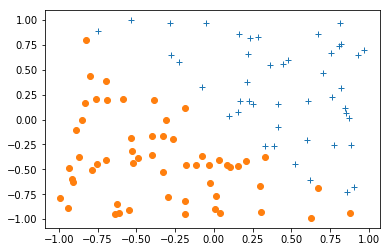

In [51]:
L = 100
n = 2
xtab = -1+2*random.rand(n,L+1)
s = sum(xtab,axis=0)
ytab = ones((L+1))
ytab[s<1] = -1

pos = find(s>=0)
neg = find(s<0)
plot(xtab[0,pos],xtab[1,pos],'+')
plot(xtab[0,neg],xtab[1,neg],'o')

On cherche à faire de la classification. Etant donnés 
+ les croix représentant des points $x_i$ d'étiquette $y_i = 1$ 
+ et les cercles représentants d'autres points $x_i$ d'étiquette $y_i = -1$, 
on cherche un vecteur $w$ de $\mathbb{R}^2$ (vecteur normal à la droite séparatrice) tel que la droite d'équation $w^\top x =0$ sépare les croix et les cercles.

Une manière de le faire est de minimiser la fonction de $\mathbb{R}^2$ dans $\mathbb{R}$ suivante : 
$f_\lambda(w) := \sum_{i=0}^L f_{\lambda,i}(w)$, où
$$
f_{\lambda,i}(w) = y_i(w^\top x_i) + \lambda w^\top w.
$$

### a) Ecrire une fonction **df(w,i,param)**.

Elle évalue $\nabla f_{\lambda,i}(w)$. 

On considère que la liste **param** contient le tableau des points $x_i$ (taille $2\times (L+1)$), le tableau des étiquettes $y_i$ et le paramètre $\lambda$.

In [64]:
def df(w,i,param) :
    #gradient = yi*xi + 2*lambda*w
    x = param[0]
    y = param[1]
    lambd = param[2]
    xi = np.array([x[0,i],x[1,i]])
    yi = y[i]
    gradient = yi*xi + 2*lambd*np.array(w)
    return(list(gradient))

In [65]:
param = [xtab,ytab,1]
df([0,0],4,param)

[-0.3282135064110874, 0.3787334516249963]

### b) Appel de SGPF

Appeler la fonction **SGPF** écrite à la question 1 pour minimiser la fonction $f_\lambda$, en partant de $w_0 = (0,0)$ avec **itmax = 10L**, **alpha** $=0.001$ et $\lambda = 1$.

Afficher le dernier itéré calculé.

In [66]:
w0 = [0,0]
L = 100
alpha = 0.001
itmax = 10*L
param = [xtab,ytab,1]
x = SGPF(w0,df,L,alpha,itmax,param)

In [67]:
print(x[itmax])

[-0.07148323381988086, -0.11458503962748307]


### c) Tracés

Tracer sur le même graphe
+ les croix
+ les cercles
+ et la droite séparatrice obtenue.

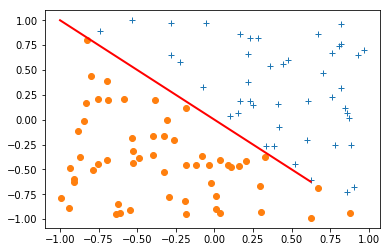

In [73]:
x1 = -(x[itmax][0]/x[itmax][1]*(-1))
x2 = -(x[itmax][0]/x[itmax][1]*(1))

plot(xtab[0,pos],xtab[1,pos],'+')
plot(xtab[0,neg],xtab[1,neg],'o')
plot([-1,x1],[1,x2],'r',lw=2)

### d) Faire le tracé de l'évolution de la fonction $f_\lambda$ au fur et à mesure des itérations.

In [74]:
print(f)

<built-in method f of mtrand.RandomState object at 0x00000278086AAA20>
